In [1]:
import os
from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine 
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
from numpy import int16
from enum import Enum
from dataframe_image import export

In [2]:
# Using enum class create enumerations
class Constante(Enum):
   glob = ""
   specific = "2022-02-01"

In [3]:
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    agent_username, COUNT(*) AS nbre,
    dsd.organisation,
    dsd.timeEnd as entry_date
FROM
    caris_db.dreams_surveys_data dsd
WHERE
    dsd.timeEnd >= '{Constante.specific.value}'
GROUP BY agent_username
'''

agent = pd.read_sql_query(query,engine,parse_dates=True)
# get the test excel file from Query

# close the pool of connection
engine.dispose()

## Agent DREAMS sortant du Systeme

In [4]:
agent.rename(columns={'agent_username':'username'},inplace=True)
agent

,username,nbre,organisation,entry_date
0,2davy,220,CARIS,2022-02-09 11:12:49
1,2diegoarmando,25,CARIS,2022-02-14 14:56:24
2,2eliona,27,CARIS,2022-02-11 15:09:01
3,2gerald,6,CARIS,2022-02-14 16:18:47
4,2wilnes,10,CARIS,2022-02-09 19:46:26
5,2woodridchard,171,CARIS,2022-02-04 14:18:53
6,6chelot,95,CARIS,2022-02-11 18:25:07
7,6clermane,16,CARIS,2022-02-07 05:27:51
8,6edwina,9,CARIS,2022-02-14 13:09:28
9,6fenide,12,CARIS,2022-02-14 22:48:19


In [5]:
agent_name = pd.read_excel("caris-test_users_28d6565d382d48b4b97c742c6a7872e0.xlsx")

In [6]:
agent_name = agent_name[["username","name"]]

## Liste de tous les agents avec Leur nom

In [7]:
agent_name

,username,name
0,1aldonzar,elcie aldonzar
1,1alexandra,Alexandra Joseph
2,1annuelle,Annuelle Eustache
3,1cadet,Memie Cadet
4,1claudius,Claudius Gladys
...,...,...
761,s2julnor,Julnor Beaubrun
762,s2mirlene,Vernet Mirlene
763,stfleur,Jesula St Fleur
764,sylvietest,sylvie rousseau


## MERGE (Vlookup)

In [8]:
performanceAgents = agent_name.merge(agent,on="username",how="inner")

In [9]:
performanceAgents

,username,name,nbre,organisation,entry_date
0,2davy,Jean Davy Mexil,220,CARIS,2022-02-09 11:12:49
1,2diegoarmando,Diego Armando Dorlean,25,CARIS,2022-02-14 14:56:24
2,2eliona,Eliona Fredly,27,CARIS,2022-02-11 15:09:01
3,2gerald,Gerald Poteau,6,CARIS,2022-02-14 16:18:47
4,2wilnes,Gerant Louis Wilnes,10,CARIS,2022-02-09 19:46:26
5,2woodridchard,Wood-Ridchard Bon,171,CARIS,2022-02-04 14:18:53
6,6chelot,Chelot Demosthene,95,CARIS,2022-02-11 18:25:07
7,6clermane,Clermane Glaude,16,CARIS,2022-02-07 05:27:51
8,6edwina,Edwina Guerrier,9,CARIS,2022-02-14 13:09:28
9,6fenide,Fénide Sèvère,12,CARIS,2022-02-14 22:48:19


In [10]:
performanceAgents.nbre.sum()

767

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
from datetime import datetime
date_du_jour = datetime.today().strftime("%d_%m_%Y")

In [13]:
orderdata = performanceAgents.nbre.sort_values().to_list()

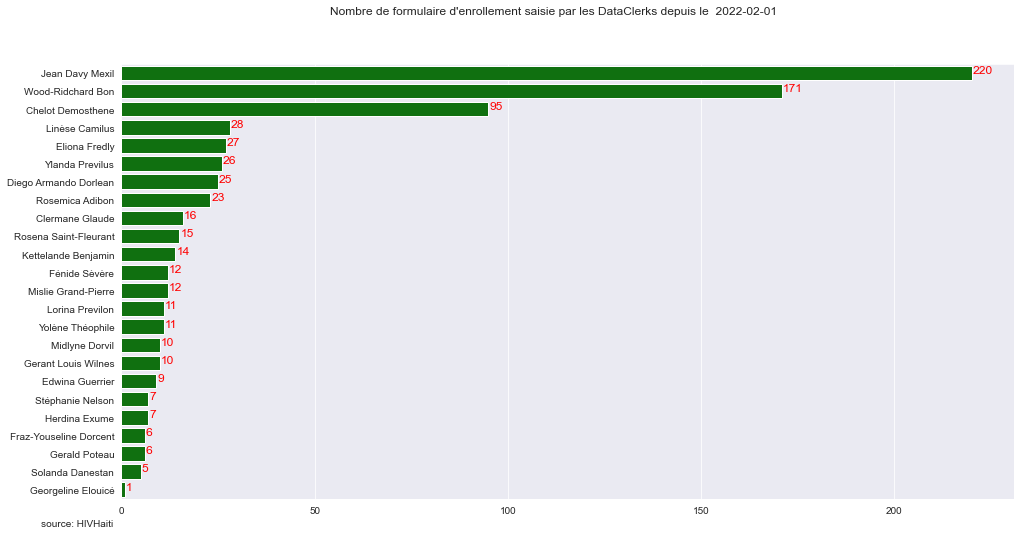

In [14]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de formulaire d'enrollement saisie par les DataClerks depuis le  {Constante.specific.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )

    #plt.savefig(f"saisie_screening_{date_du_jour}",dpi=1000)
    plt.savefig(f"saisie_screening",dpi=1000)
except ValueError:
    print("No data is avalaible")

In [15]:
performanceAgents.nbre.sum()


767

In [16]:
export(pd.DataFrame({f"Nombre total d'enrolement depuis le {Constante.specific.value}": [performanceAgents.nbre.sum()]}),'total_enrolement.png')


[0215/123422.222252:INFO:headless_shell.cc(659)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmpf6jgvpau/temp.png.


In [17]:
performanceAgents.to_excel(f"performance_formulaire_denrolement.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_{date_du_jour}.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_depuis_1Mars2021.xlsx",index=False,na_rep="NULL")